In [1]:
from conv_detector  import ConvDetector
from generators import BDIGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import Mean, MeanIoU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

In [3]:
ConvDetector_net = ConvDetector(input_sh=(128, 128, 3), dp_rate=0.45)
ConvDetector_net.compile(optimizer=Adam(), 
                    loss_fn=[
                        MeanSquaredError(), 
                        MeanSquaredError(), 
                        BinaryCrossentropy()
    ])
    
generator = BDIGenerator(input_sh=(128, 128, 3))
images = []
bb = []
bba = []
cll_labels = []
for (sample_n, sample) in enumerate(iter(generator)):

    if sample_n == 1000:
        break

    images.append(sample[0])
    bb.append(sample[1])
    bba.append(sample[2])
    cll_labels.append(sample[3])
    
images = np.asarray(images)
bb = np.asarray(bb)
bba = np.asarray(bba)
cll_labels = np.asarray(cll_labels)

    

images = images / 255.0
images = (images - np.mean(images)) / np.std(images)
bba = (bba - np.mean(bba)) / np.std(bba)

ConvDetector_net.fit(images, (bb, bba, cll_labels),
           epochs=1, batch_size=32) 
     
ConvDetector_net.save_weights(filepath="c:\\Users\\1\\Desktop\\drone_solution_meta\\models_weights\\yolo_weights.weights.h5")
#ConvDetector_net.load_weights(filepath="c:\\Users\\1\\Desktop\\drone_solution_meta\\models_weights\\yolo_weights.weights.h5")
pred_boxes, pred_logits = ConvDetector_net.predict(images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - bounding_box_loss: 12915.0498 - classification_loss: 4.4915
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 763ms/step


In [4]:
from inference_test import grads_inference

In [5]:
random_idx = np.random.randint(0, images.shape[0], 3)
images_batch = images[random_idx]
test_heatmaps = grads_inference(inputs=images_batch, model=ConvDetector_net.grad_model)

AttributeError: 'ConvDetector' object has no attribute 'inputs'

In [4]:
pred_boxes = pred_boxes.astype("int")
print(pred_boxes[56])

[187  84 117  97]


In [5]:
generator = BDIGenerator(input_sh=None)
images = []
bb = []
bba = []
cll_labels = []
for (sample_n, sample) in enumerate(iter(generator)):

    if sample_n == 1000:
        break

    images.append(sample[0])
    bb.append(sample[1])
    bba.append(sample[2])
    cll_labels.append(sample[3])
    
images = np.asarray(images)
bb = np.asarray(bb)
bba = np.asarray(bba)
cll_labels = np.asarray(cll_labels)

In [6]:
bb = bb.astype("int")

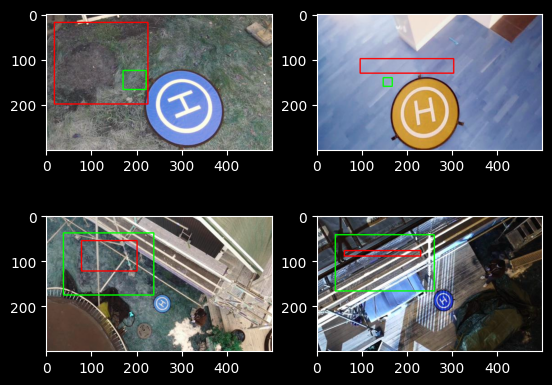

In [7]:
plt.style.use("dark_background")
fig, axis = plt.subplots(nrows=2, ncols=2)

for i in range(axis.shape[0]):
    for j in range(axis.shape[1]):

        
        random_idx = np.random.randint(0, images.shape[0])
        image_sample = images[random_idx]
        image_sample = cv2.rectangle(image_sample, bb[random_idx][:2], bb[random_idx][2:], color=(0, 255, 0), thickness=2)
        image_sample = cv2.rectangle(image_sample, pred_boxes[random_idx][:2], pred_boxes[random_idx][2:], color=(255, 0, 0), thickness=2)
        
        axis[i, j].imshow(image_sample)

plt.show()

In [15]:
random_idx = np.random.randint(0, images.shape[0])
image_sample = images[random_idx]
res_sample = cv2.resize(image_sample, (128, 128))
res_sample = np.expand_dims(res_sample, axis=0)

pred_box, pred_logit = ConvDetector_net.predict(res_sample)
pred_box = pred_box[0].astype("int")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


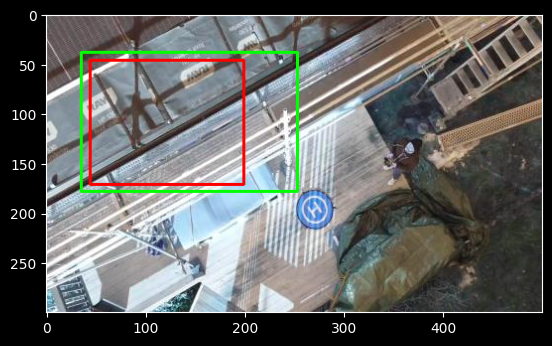

In [16]:
fig, axis = plt.subplots()
image_sample = cv2.rectangle(image_sample, bb[random_idx][:2], bb[random_idx][2:], color=(0, 255, 0), thickness=2)
image_sample = cv2.rectangle(image_sample, pred_box[:2], pred_box[2:], color=(255, 0, 0), thickness=2)
axis.imshow(image_sample)

In [ ]:
random_image_batch = np.random.randint(0, images.shape[0], 100)
images_batch = images[random_image_batch]
